<a href="https://colab.research.google.com/github/IrisFDTD/PINNs-for-education/blob/main/PINN_for_optics_eikonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizing Physical Informed Neural Networks (PINN) for solving eikonal-based Ordinary Differential Equations

+ This notebook has been implemented by Paula Robredo Mexía <775198@unizar> and Sergio Gutiérrez Rodrigo <sergut@unizar.es> as part of a Final Degree Thesis at the University of Zaragoza, 2023.
+ The code builds upon the 2nd-order ODE implementation using Physics-Informed Neural Networks (PINNs) done by Luis Medrano Navarro, Luis Martin Moreno and Sergio G Rodrigo ([Solving differential equations in physics with Deep Learning: a beginner’s guide](https://arxiv.org/abs/2307.11237)).

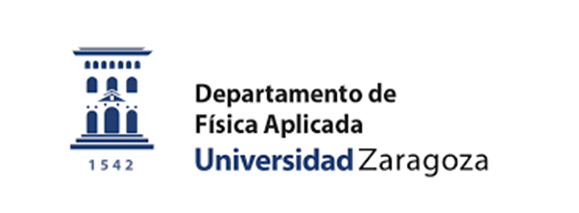

# Definition of the problem

## Eikonal

The Eikonal equation:

\begin{equation}
    \frac{d}{ds}\left(n\frac{d\mathbf{r}}{ds}\right)=\nabla n
\end{equation}

with vector notation $\mathbf{r}=(x,y,z)$. The left-hand side of this equation represents the curvature of the ray, while on the other side, we find the gradient of the refractive index. As a result, the ray will always bend towards regions of maximum gradient. If we consider an isotropic medium, the right-hand side would be zero since $n$ would not depend on spatial directions. This is why the trajectories are straight lines.

## GRadient-INdex medium (GRIN)

For a GRIN medium, particularly an optical fiber, it is consider a quadratic refractive index

\begin{equation}
    n^2(x,y)=n_o^2\left(1-g^2(x^2+y^2)\right)
\end{equation}

where $g$ is a real constant characteristic of the medium, and $n_o$ is the refractive index along the axis of symmetry $z$. It can be observed how $n(x,y)$ decreases as we move radially away from this axis. We will mainly solve two cases: one that leads to an ordinary differential equation and the latter to two coupled differential equations.

We can approximate using the Taylor series expansion. We obtain:

$$n(x, y) \approx n_o - \frac{g^2(x^2 + y^2)}{2}$$
where if $g^2(x^2 + y^2) \ll 1$.

Now, we are not going to make this approximation, so we need to obtain the gradient from the first expression (which can be analytically derived by performing the calculations). Finally, considering the second approximation and the equation:

$$\frac{d}{dz}\left(n\frac{dr}{dz}\right) = \nabla n$$

where $r = (x, y)$. The equations to solve are as follows:

$$n_o \frac{d^2x}{d^2z} = -n_o \frac{g^2x}{\sqrt{1 - g^2(x^2 + y^2)}}$$

$$n_o \frac{d^2y}{d^2z} = -n_o \frac{g^2y}{\sqrt{1 - g^2(x^2 + y^2)}}$$

# Important libraries

In [1]:
## Tensorflow Keras and rest of the packages
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
from tensorflow import keras
import time

# Definition of the PINN

In [2]:
class ODE_2nd(tf.keras.Model):
    def set_ODE_param(self,g,z0,x0,dx_dz0):
        '''
        Set parameters and initial conditions for the ODE
        '''
        self.g=g
        self.z0=z0
        self.x0=x0
        self.dx_dz0=dx_dz0

    def train_step(self, data):
        '''
        Training ocurrs here
        '''
        z, x_true = data

        #We have 4 initial conditions — there's no need to list them separately as x=(x1, x2) = (x, y).
        z0=tf.constant([self.z0], dtype=tf.float32)
        print(z0.shape)
        x0_true=tf.constant(self.x0, dtype=tf.float32)
        dx_dz0_true=tf.constant(self.dx_dz0, dtype=tf.float32)
        # Definition of the g constant
        g=tf.constant([self.g], dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(z)
            tape.watch(x_true)
            # Initial conditions
            tape.watch(z0)
            tape.watch(x0_true)
            # Derivaties
            tape.watch(dx_dz0_true)

            # The gradient will also output the derivative with respect to z for both outputs.
            with tf.GradientTape() as tape0:
                    tape0.watch(z0)
                    # Two output neurons --> two outputs x0=(x01, x02).
                    x0= self(z0,training=False)
                    tape0.watch(x0)
            # This will be dx01_dz0 and dx02_dz0 because we have stated that x0=(x01, x02).
            dx_dzpred0 = tape0.jacobian(x0, z0)
            with tf.GradientTape() as tape1:
                tape1.watch(z)
                with tf.GradientTape() as tape2:
                    tape2.watch(z)
                    # Two output neurons --> two outputs x0=(x01, x02).
                    x = self(z,training=False)
                    tape2.watch(x)
                dx_dz = tape2.jacobian(x, z)
                tape1.watch(x)
                tape1.watch(dx_dz)
            d2x_dz2 = tape1.jacobian(dx_dz, z)
            tape.watch(x)
            tape.watch(dx_dz)
            tape.watch(d2x_dz2)
            dx_dz=tf.squeeze(dx_dz)
            d2x_dz2=tf.squeeze(d2x_dz2)
            dx_dz=tf.reshape(dx_dz,shape=x.shape)
            d2x_dz2=tf.reshape(d2x_dz2,shape=x.shape)
            print("x shape=",x.shape)
            print("dx_dz shape",dx_dz.shape)
            print("d2x_dz2 shape",d2x_dz2.shape)

            #Loss= ODE+ boundary/initial conditions
            x0_true=tf.reshape(x0_true,shape=x[0].shape)
            dx_dz0_true=tf.reshape(dx_dz0_true,shape=dx_dzpred0.shape)

            #With the definition of x0_true and dx_dz0_true, we already take into account the 4 initial conditions along with the boundary conditions.
            #To formulate the equation, we can utilize the fact that x=(x1, x2) and express it in a vectorial manner.

            #In case a complex number emerges, change the sign of the square root and treat it as an absorbing medium.
            loss= self.compiled_loss(x0,x0_true)\
                  +self.compiled_loss(d2x_dz2,-(g**2)*x/tf.sqrt(1-g**2*(tf.reduce_sum(tf.square(x)))))\
                  +self.compiled_loss(dx_dzpred0,dx_dz0_true)

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(x_true, x)#Aqui tambien tenemos x_true=(x1_true, x2_true) por lo que tiene en cuenta las dos
        return {m.name: m.result() for m in self.metrics}

# Run the PINN

In [ ]:
N_train = 20

zmin = 0.0
g=0.5
g_ref=0.5

# Period = 2.0*np.math.pi/g_ref
zmax =2.0*np.math.pi/g_ref

# Initial conditions
z0=0.0
x0=[1.0,0.0]
dx_dz0=[0.0,0.2]

if(g**2*np.linalg.norm(x0)**2>1.0):
  print("The condition is not satisfied: sqrt(1-g**2*(x**2+y**2) real")

# We generate the values of z within the domain.
z_train=np.linspace(zmin,zmax,N_train)
z_train=np.reshape(z_train,(N_train,1))
print(z_train.shape)


# Input and output neurons (from the data)
input_neurons  = 1
output_neurons = 2

# Hiperparameters
batch_size = 1
epochs = 1400

# Define the model
initializer = tf.keras.initializers.GlorotUniform(seed=5)
activation='tanh'
input=Input(shape=(input_neurons,))
x=Dense(50, activation=activation,kernel_initializer=initializer)(input)
x=Dense(50, activation=activation,kernel_initializer=initializer)(x)
x=Dense(50, activation=activation,kernel_initializer=initializer)(x)
output = Dense(output_neurons,kernel_initializer=initializer,activation=None)(x)

# Build the model
model=ODE_2nd(input,output)

# Set ODE parameters and initial conditions
model.set_ODE_param(g=g,z0=[z0],x0=x0,dx_dz0=dx_dz0)

#Define the metrics, optimizer and loss
loss= tf.keras.losses.MeanSquaredError()
metrics=tf.keras.metrics.MeanSquaredError()
optimizer= Adam(learning_rate=0.001)

model.compile(loss=loss,
          optimizer=optimizer,
          metrics=metrics)
model.summary()

# Just use `fit` as usual
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=10000,
                                            restore_best_weights=True)
# We create an auxiliary y_train.
print(z_train.shape)
y_train=np.zeros((z_train.shape[0],2))
print(y_train.shape)
inicial=time.time()
history=model.fit(z_train, y_train,batch_size=1, epochs=epochs,verbose=1,
                  callbacks=callback)
final=time.time()
print(final-inicial)

## Plot loss vs epochs

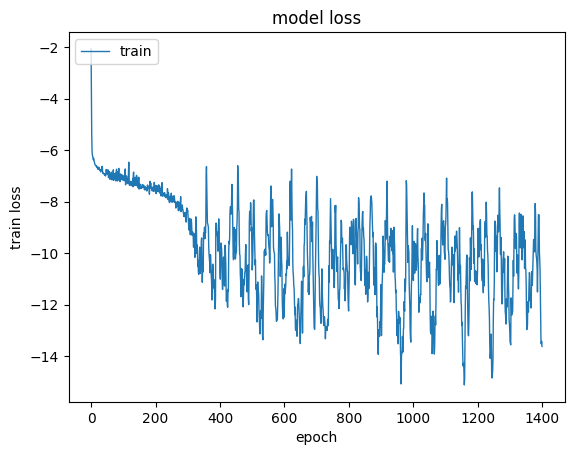

In [4]:
# summarize history for loss
plt.plot(np.log(history.history['loss']),marker='o',markersize=0.0, linewidth=1)
plt.title('model loss')
plt.ylabel('train loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# Runge Kutta (for comparison)

In [5]:
def rungekutta4(f, x0, t):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(x[i])
        k2 = f(x[i] + k1 * h / 2.)
        k3 = f(x[i] + k2 * h / 2.)
        k4 = f(x[i] + k3 * h)
        x[i+1] = x[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return x

In [6]:
#Function that returns the equations of eikonal fiber
def eikonal_fiber(x_sol):
  dx_dz = x_sol[2]
  dy_dz = x_sol[3]
  dx2_dz2 = -(g**2)*x_sol[0]/np.real(cmath.sqrt(1-(g**2*(x_sol[0]**2+x_sol[1]**2))))
  dy2_dz2 = -(g**2)*x_sol[1]/np.real(cmath.sqrt(1-(g**2*(x_sol[0]**2+x_sol[1]**2))))
  return np.array([dx_dz, dy_dz,dx2_dz2, dy2_dz2])


def generate_data(n_steps,tmax,init_cond,batch_size):
  data=[]
  targets=[]
  t = np.linspace(0, tmax, n_steps)
  for i in range (1,batch_size+1):
    x0 = np.random.uniform(-1.0, 1.0)
    y0 = np.random.uniform(-1.0, 1.0)
    z0 = np.random.uniform(-1.0, 1.0)
    results =  rungekutta4(f=eikonal_fiber, x0=init_cond,t=t)
    data.append(results[:n_steps])
  return np.array(data)

In [7]:
#Definition of the Analytical solution, with its parameters
L=zmax     # Igual que en entrenamiento funciona
n_steps=500 # Número de z's

#Initial conditions of space and solution
x_inicial,y_inicial=x0 # Defined in Run the PINN
x_prime_inicial,y_prime_inicial=dx_dz0 # Defined in Run the PINN

In [8]:
batch_size=1
init_cond = [x_inicial, y_inicial, x_prime_inicial, y_prime_inicial]
inicial=time.time()
data=tf.squeeze(generate_data(n_steps,L,init_cond,batch_size))
final=time.time()
print(final-inicial)
print(data.shape)
x_final=data[:,0]
y_final=data[:,1]

0.033856868743896484
(500, 4)


# Analytical ray path ($g^2(x^2+y^2)\ll 1$)

In [9]:
def PathRay(z,r_o=0.5,r_1=-0.8,g=0.25):
    # Periodo = 2*pi/g
    return r_o*np.cos(g*z)+r_1*np.sin(g*z)/g

z=np.linspace(0,L,n_steps)
z=np.reshape(z,(n_steps,1))
print(z.shape)

print('g=',g)
r_o=np.sqrt(x_inicial**2+y_inicial**2)
r=PathRay(z,r_o=r_o,r_1=x_prime_inicial,g=g)
print(r.shape)


(500, 1)
g= 0.5
(500, 1)


# PINN prediction

In [11]:
z_red=z_train
xy_pred=model.predict(z_red)

1/1 [==============================] - 0s 49ms/step


# Plot the results

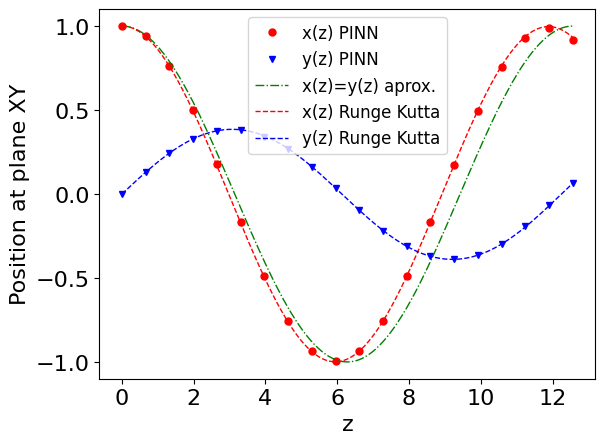

Solution at z=0 : 1.0007325 -0.00035066903


In [15]:
plt.plot(z_red, xy_pred[:,0], color="red",marker='o',markersize=5.0, linestyle='solid', linewidth=0.0, label="x(z) PINN")
plt.tick_params(labelsize = 16)
plt.plot(z_red, xy_pred[:,1], color="blue",marker='v', markersize=5.0,linestyle='solid', linewidth=0.0, label="y(z) PINN")
plt.plot(z, r, color="green",marker='o',markersize=0.0, linestyle='-.', linewidth=1, label="x(z)=y(z) aprox.")
plt.plot(z,x_final,color="red",markersize=0.0, linestyle='--', linewidth=1,  label="x(z) Runge Kutta")
plt.plot(z,y_final,color="blue",markersize=0.0, linestyle='--', linewidth=1,  label="y(z) Runge Kutta")

plt.legend(fontsize=12)
plt.xlabel("z",fontsize=16)
plt.ylabel("Position at plane XY",fontsize=16)
plt.show()

print("Solution at z=0 :",xy_pred[0,0],xy_pred[0,1])

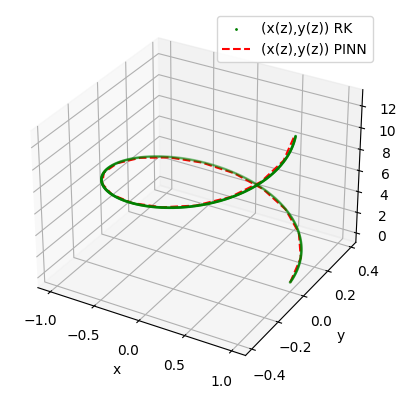

In [16]:
x=np.transpose(np.array([xy_pred[:,0]]))
y=np.transpose(np.array([xy_pred[:,1]]))
ax = plt.axes(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.scatter(x_final,y_final,z, c='g',s=1,label="(x(z),y(z)) RK")
ax.plot3D(x, y, z_red, color='red', linestyle='--',linewidth=1.5, label="(x(z),y(z)) PINN")
ax.legend()
